<a href="https://colab.research.google.com/github/ShengHangNB/Datasets/blob/master/MLAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Assignment 2 - C4.5 Decision Tree Algorithm**    

Student name: Hang Sheng       
Student number: 13665664



# **Implementation of algorithm**

## **1. Prepare for the iris dataset**

Iris dataset - used for implementating the algorithm

This dataset can be viewed and downloaded from the UCI Machine Learning Repository datasets: https://archive.ics.uci.edu/ml/datasets/Iris

In [97]:
# import the libraries that will be used in this assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [98]:
# Load the csv of the prepared iris datasets which have been uploaded to my github beforehand
df = pd.read_csv("https://raw.githubusercontent.com/ShengHangNB/Datasets/master/iris.csv")
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## **2. Preprocess and preview of the dataset**

After loading the csv file of iris dataset, I convert the string type of the target values to numerical type.

The numerical type of target values can be helpful for the decision tree performance visulization later.

In [99]:
def change_target_type(x):
  '''
    convert the string type of the target values to numerical type
    in order to visualize the results in the scatter plot later
  '''
  if x == 'Iris-setosa':
    return 0

  elif x == 'Iris-versicolor':
    return 1
  
  elif x == 'Iris-virginica':
    return 2

# use .apply() to apply to the "class" column with the defined change_target_type() function
# the return columns should be assigned to df.loc[:,"class"]
# df.loc[:,"class"] means all rows and only the "class" column
df.loc[:,"class"] = df["class"].apply(change_target_type)

# check the first five rows
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Check whether thare are some null values for each attribute

In [100]:
df.isnull().any()

sepal length    False
sepal width     False
petal length    False
petal width     False
class           False
dtype: bool

Check the data type and non-null count values for each attribute

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


View the statistics for all numerical attributes in a table

For each numerical data, the calculated statistical results will include count, mean, standard deviation, minimum, maximum, and 25th percentile, 50th percentile and 75th percentile.

In [102]:
df.describe()

,sepal length,sepal width,petal length,petal width,class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


## **3. Division of the dataset**

In this part I split the whole datasets into two sub-datasets:

1.   The attributes datasets X_total (DataFrame type) 
2.   The target datasets y_total (Series type)

Then I use the **train_test_split** function, set the **test_size = 0.33** to split X_total and y_total datasets, the sub-datasets are as followings:

1.   X_train: accounts for 67% of the attributes datasets X_total
2.   X_test: accounts for 33% of the attributes datasets X_total
3.   y_train: accounts for 67% of the target datasets y_total
4.   y_test: accounts for 33% of the target datasets y_total



In [103]:
# get the attributes by using the df.keys() functions,
# then extract all the attributes except for the target name by using the slice method df.keys()[:-1]
attrs = df.keys()[:-1]

# split the datasets into the attributes datasets X_total (DataFrame type) and target datasets y_total (Series type)
print("The number of samples in the total datasets are {}\n".format(df.shape[0]))
X_total = df[attrs]
y_total = df.iloc[:,-1]

# Set the random_state = 48 (random seed) to guarantee that my split will be always the same
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.33,random_state = 48)


print("The number of samples in the training datasets are {}".format(X_train.shape[0]))
print("The number of samples in the testing datasets are {}".format(X_test.shape[0]))

The number of samples in the total datasets are 150

The number of samples in the training datasets are 100
The number of samples in the testing datasets are 50


## **4. Define my tool class**

In this part I define a tool class named "Myutils" that will be used in subsequent c4.5 decision tree construction

Here are the brief description of the function in this class:


1.   get_split_pointSet(): Discretize continuous attributes through the dichotomy
2.   get_discrete_variables(): Convert continuous variables through the split point into categorical variables 
3.   compute_entropy(): calculate the information entropy
4.   compute_info_gain_ratio(): Calculate the information gain ratio of the specified attribute for a continuous variable


In [104]:
class Myutils:
  def get_split_pointSet(self,attr_series):
    '''
    Discretize continuous attributes through the dichotomy

    Parameters:
      attr_series (Series type) : The value of an attribute column passed in 

    return value：The array with all division points
    '''

    # use the .unique() functioon to get the unique values from the input
    # the .unique() function can automatically sort the array when recalling
    unique_values = np.unique(attr_series)

    # use the list comprehension to calculate the arithmetic mean between two points in unique_values
    result = [(unique_values[i] + unique_values[i+1]) / 2  for i in range(len(unique_values)-1)]

    return np.unique(result)
    
  def get_discrete_variables(self,X,attr,split_point):
    '''
    Convert continuous variables through the split point into categorical variables 
    which greater than the split point or smaller than the split point

    Parameters:
      X (DataFrame type) : The passed in datasets 
      attr (String type) : used to select the related attribute column 
      split_point (float type) : Divided/split point 

    return value: the new column with categorical variables 
    '''

    # make the sequence of scalars in bins_to_cut list
    bins_to_cut = [min(X[attr]),split_point,max(X[attr])]

    # Specifies the labels for the returned bins in labels_to_cut list
    labels_to_cut = [attr + ' < ' + str(split_point), attr + ' > ' + str(split_point)]

    # use .cut() function to get the categorical variables column, left-include the first interval
    categorized_column = pd.cut(X[attr], bins= bins_to_cut , labels = labels_to_cut, include_lowest=True)
    return categorized_column

  def compute_entropy(self,y):
    '''
    calculate the information entropy 

    Parameters:
      y (Series type): the target values passed in 

    return value: 0.0 or calculated information entropy
    '''
    
    # if the length of y less than 2, it means there are no more uncertainty
    # in this case, the entropy is 0.0
    if len(y) < 2:
      return 0.0
    
    # if the unique values in y are less than 2, it means that all sampls have the same feature values
    # in this case, the entropy is 0.0
    if len(np.unique(y)) < 2:
      return 0.0

    # calculate the counts of value in y series, the normalize =True means the counts are presented as the frequency
    freq = y.value_counts(normalize=True)
    return -(freq * np.log2(freq + 1e-6)).sum()

  def compute_info_gain_ratio(self,X,y,attr,split_point_list):
    '''
    Calculate the information gain ratio of the specified attribute for a continuous variable
    
    Parameters:
      X (DataFrame type): Datasets with the attributes values
      y (Series type): Datasets with the target values 
      attr (String type): The attribute for calculating the information gain rate 
      split_point_lst (numpy.array type): Divided points array

    return values: Result of the calculate information gain ratio, and the best split point of float type     
    '''

    # Define the variables best_split_point, best_info_gain, split_entropy
    best_split_point = 0.0
    best_info_gain = 0.0
    split_entropy = 0.0

    # if the length of the split_point_list is 0, it means there are no split point
    # further more, there is no need to consider this attribute
    # so the result could be 0.0 and None
    if len(split_point_list) == 0:
      return 0.0, None

    else:
      # use the for loop to calculate the best information gain and best split point
      for split_point in split_point_list:

        # Divide the X datasets to the sub-datasets that the values are lower than the split point 
        lower_index_boolean = X[attr] < split_point
        lower_X = X[lower_index_boolean]
        lower_y = y[lower_index_boolean]

        # Divide the X datasets to the sub-datasets that the values are higher than the split point
        upper_index_boolean = X[attr] > split_point
        upper_X = X[upper_index_boolean]
        upper_y = y[upper_index_boolean]
        
        # compute the entropy of target values
        Ent_D = self.compute_entropy(y)
        
        # Calculate the probability of these two sub-data sets occupying the total data set separately
        lower_p = len(lower_X) / len(X)
        upper_p = len(upper_X) / len(X)

        # compute the entropy of the sub-datasets that all the values are lower than the split point
        lowersets_entropy = lower_p * self.compute_entropy(lower_y)

        # compute the entropy of the sub-datasets that all the values are higher than the split point
        uppersets_entropy = upper_p * self.compute_entropy(upper_y)   
        
        # compute the information gain for this split point
        info_gain = Ent_D - (lowersets_entropy + uppersets_entropy)

        # get the categorical values for these numerical values lower or higher than the split point 
        categorized_column = self.get_discrete_variables(X,attr,split_point)

        # computer the split information entropy
        split_entropy = self.compute_entropy(categorized_column)

        # select the best information gain and best split point
        if info_gain > best_info_gain:
          best_info_gain = info_gain
          best_split_point = split_point

      # use the best information gain to compute the information gain ratio
      info_gain_ratio = best_info_gain / split_entropy
      return info_gain_ratio, best_split_point


In [105]:
# Instantiate an object of Myutils class to prepare for the subsequent c4.5 decision tree construction
utils = Myutils()

## **5. Define 2 object-oriented classes to construct the decision tree**

1. TreeNode:

  This class is mainly used to **generate the tree node** and **print the node's details** recursively. 
  
  The brief description of the two functions in this class are:
  
  make(): split the attribute according to the C4.5 algorithm and generate the child node by the value of split attribute.
  
  print_node_details(): print the information details of each node, this function is used to help me understand the tree structure and draw the decision tree structure later.



2. TreeC4_5:

  This class is mainly **generates the root tree node**, **fit the decision tree model** and **make predictions** by the fitted model.

  The brief description of the three functions in this class are:

  fit(): fit the model by recall the make() function in the root node

  make_decision(): predict the decision for each sample in the fitted model

  predict(): passed in the testing datasets and predict the sample one by one, then return the list of decisions for each sample.
  

In [106]:
class TreeNode:
  '''
  Construct the entire tree by recursive algorithm
  '''
  def __init__(self,X,y, node_name="", default_decision=None):
    self.X = X # Passed in attributes datasets 
    self.y = y # Passed in target datasets
    self.name = node_name 
    self.default_decision = default_decision # decision from parent node
    self.decision = None
    self.entropy = 0.0 # record this node's information entropy
    self.attrs_info_gain_ratio = {} # record the attriubte with its info gain ratio in dictionary structure
    self.split_point = 0.0 # record the best split point
    self.split_attr = None # record the best split attribute
    self.split_point_info = [] # store the best split point list, best_split_point, its split attribute and max info gain ratio in this list
    self.children = {} # store the child node in dictionary structure

  def make(self):
    # use the mode of target datasets to determine the default decision
    # After the root node, the children node should have the default decision passed by their parent node
    if self.default_decision is None:
      self.default_decision = self.y.mode()[0]

    # if there are no data in datasets, use the default decision passed by parent node to determine the decision 
    if len(self.X) == 0:
      self.decision = self.default_decision
      return

    else:
      # use c4.5 algorithm to split the attribute below

      # calculate the information entropy of based on the current target values
      self.entropy = utils.compute_entropy(self.y)
      # if there is only one type of target values, determine the decision by this value 
      target_unique_values = self.y.unique()
      if len(target_unique_values) == 1:
        self.decision = target_unique_values[0]
        return

      else:
        # initialize the value of max information gain ratio, best split point and best split point list
        max_infoGain_ratio = 0.0
        best_split_point = 0.0
        best_split_point_list = []
        for attr in self.X.keys():
          # get the split point set of this attribute
          split_point_list = utils.get_split_pointSet(self.X[attr])
          if len(split_point_list) == 0:
            # No split point here, which means that this attribute column has only one type of value
            continue

          else:
            # calculate the information gain ratio and splitted point of each attribute
            infoGain_ratio,splited_point = utils.compute_info_gain_ratio(self.X, self.y, attr, split_point_list)
            # store each attribute and its information gain ratio in the dictionary
            self.attrs_info_gain_ratio[attr] = infoGain_ratio

            # select the max information gain ratio
            if infoGain_ratio > max_infoGain_ratio:
              max_infoGain_ratio = infoGain_ratio
              self.split_attr = attr
              best_split_point_list = split_point_list
              best_split_point = splited_point

        # append the best split point list, best_split_point, its split attribute and max info gain ratio to split_point_info list
        self.split_point_info.append(list(best_split_point_list))
        self.split_point_info.append([best_split_point,self.split_attr,max_infoGain_ratio])
        self.split_point = best_split_point

        # if there exists a split point, the tree could be split into the child node
        if self.split_point != 0.0:
          # make a copy of attributes datasets to allow to add a new column
          X_copy = self.X.copy()

          # define the name of the new column, and then add it to the X_copy
          discrete_class = self.split_attr + '-group'
          X_copy.loc[:,discrete_class] = utils.get_discrete_variables(X_copy,self.split_attr,self.split_point)
          
          # create a child node by the categorical values, such as "petal length" < 2.45 or "petal length" > 2.45
          for value in X_copy[discrete_class].unique():
            index_boolean = X_copy[discrete_class] == value
            self.children[value] = TreeNode(
                              self.X[index_boolean],
                              self.y[index_boolean],
                              node_name = value,
                              default_decision=self.default_decision,)
            # recursively generate the node until reaching the leaf node
            self.children[value].make()
        
        else:
          '''
          Two issuese may happend if split_point is None
          case1: 
          Only one mode means that when attribute values are the same, the frequency of the target value is different.
          For example, if the first target value appears once and the second target value appears three times, 
          then the target value that appears three times wins and can be selected as the decision

          case2:
          if the mode is more than one, it means when the attribute values are the same, the frequency of the target value is identical.
          For example, if the first target value appears once and the second target value appears once
          then it is hard to make a decision.
          This case issue will happen in the tree construction of the first evaluation dataset later.
          '''
          # assign the mode of target values to the y_mode variable
          y_mode = self.y.mode()


          if len(y_mode) == 1:
            better_decision = y_mode[0]
            self.decision = better_decision   
            print("Issue happens!")
            print("The attribute values are the same, and the frequency of the target values is different.")
            print("Input values: ")
            print(self.X)
            print("Target values: ")
            print(self.y)
            print("Using the majority voting method to make a better decision -> ", self.decision)
            print("------------------------------------------------------------------------------------------------------------")         

          else:
            decision = y_mode[0]
            self.decision = decision
            print("Issue happens!")
            print("The attribute values are the same, but the frequency of the target values is identical")
            print("Input values: ")
            print(self.X)
            print("Target values: ")
            print(self.y)
            print("Just make a decision -> ", self.decision)
            print("------------------------------------------------------------------------------------------------------------")
          return

  def print_node_details(self):
    '''
    To print the details of each node, the output for each node will be:
      1. (First view of the node / Back to the node) : node name
      2. number of samples in this node
      3. The counts of y values
      4. The information entropy in this node
      5. every attributes with its information gain ratio
      6. The details of the splitted point
      7. The node name of the child node.
    
    if the node is the leaf node, the output will be:
      1. The node name
      2. The information entropy
      3. The determined decision 
    '''
    # intialize the time
    time = 1

    if self.split_attr is not None:
      for k,v in self.children.items():
        if len(self.split_point_info) != 0:
          # this if-else clause is to output it is the first time or the second time to view this node
          # if it is the second time to view the node, output "Back to the node"
          if time != 1:
            print("Back to the node: ",self.name)
          else:
            print("First view of the node: ",self.name)

          print("The number of the samples in this node is: ", len(self.X))
          print(self.y.value_counts())
          print("The Entropy is: {}\n".format(self.entropy))
          for i,j in self.attrs_info_gain_ratio.items():          
            print("{}'s information gain ratio is: {}".format(i,j))

          print("\nSplited by {}, its information gain ratio is {}, its splited points list is:\n {}".format(self.split_point_info[1][1],self.split_point_info[1][2],self.split_point_info[0]))
          print("Among these splited points, the best splited point is {}".format(self.split_point_info[1][0]))
          print("The child node is: {}".format(k))
          print('--------------------------------------------------------------------')
          time += 1
          v.print_node_details()
          
             
    else:
      time += 1
      print("This node is: {}, it is a leaf node".format(self.name))
      print(self.y.value_counts())
      print("The Entropy is: {}\n".format(self.entropy))
      print("The number of samples is: ", len(self.X))
      print("Determining the decision -> ",self.decision)
      print('--------------------------------------------------------------------')

In [107]:
class TreeC4_5:
  def __init__(self,X,y):
    # initiate the root node when instantiating an object of this class
    self.root = TreeNode(X,y, node_name="Root node")

  def fit(self):
    # fit the tree model
    self.root.make()

  def predict(self,samples):
    '''
    make the predictions based on the fitted model.

    Parameters:
      samples (DataFrame type): The testing datasets

    return value: the predictions array
    '''
    # create a prediction list to store the prediction
    prediction_list = []

    # make the prediction for each sample one by one in the testing datasets
    for sample_index in range(len(samples)):
      # use .iloc[index] to get the sample by the index
      sample = samples.iloc[sample_index]

      # make the prediction for the sample
      prediction = self.make_prediction(sample)

      # append the prediction to the prediction list
      prediction_list.append(prediction)
    return np.array(prediction_list)

  def make_prediction(self,sample):
    '''
    make a prediction for one sample

    Parameters:
      sample(Series type): one row of the testing datasets 

    return value: prediciton result
    '''
    current_node = self.root
    while current_node.decision is None:

      # get the attribute to split in the current node
      attribute_to_split = current_node.split_attr

      # get the value for this attribute in sample 
      attribute_value = sample[attribute_to_split]
      
      # choose the next attribute that the node should move based on the value is higher or lower than the split point
      if attribute_value > current_node.split_point:
        next_attr = current_node.split_attr + ' > ' + str(current_node.split_point)
      
      else:
        next_attr = current_node.split_attr + ' < ' + str(current_node.split_point)
          
      current_node = current_node.children[next_attr]

    # when decision found in the node, return this decision as the prediction
    return current_node.decision

# **Evaluation** #

## **1. Accuracy and error rates**

In this part I use the training datasets X_train and y_train to train the model.

Then calculate the accuracy by the testing datasets X_test and y_test.

In [108]:
dtc4_5 = TreeC4_5(X_train,y_train)
dtc4_5.fit()

decisions = dtc4_5.predict(X_test)

# got the boolean result that whther the prediction is true of false
results = decisions == y_test

# calculate the accuracy and output
accuracy = sum(results) / len(results)
print("My model's accuracy for the iris dataset is: ", accuracy)

My model's accuracy for the iris dataset is:  0.96


Then I calculate the in sample error and out of sample errors rate by make another 10 experiments

Each experiment I split the total datasets to 67% of training dataset and 33% of validation datasets.

In [109]:
# define the list in_errs and out_errs to store the result of in_errs and out_errs in each experiment
in_errs = []
out_errs = []

# define the size of training datasets
train_size = 0.67

# Considering the time comsuming, I make 10 experiments here
for random_seed in range(10):
    # Randomly split training/test data, use the random seed from 0 to 9
    X_trn, X_val, y_trn, y_val = train_test_split(
        X_total, y_total, train_size=train_size, random_state=random_seed)
    
    # Re-make a data model in each experiment
    dt = TreeC4_5(X_trn,y_trn)
    dt.fit() 
    
    # calculate the in-sample error rate and out of sample error rate respectively
    in_sample_error_rate = np.sum((dt.predict(X_trn) != y_trn)) / len(y_trn)
    out_sample_error_rate = np.sum((dt.predict(X_val) != y_val)) / len(y_trn)

    # append the results of in-sample error rate and out of sample error rate to the initialize lists
    in_errs.append(in_sample_error_rate)
    out_errs.append(out_sample_error_rate)

# convert the type of list to numpy.array 
# in order to calculate the mean and standard deviation by using the .mean() function and .std() function directly
in_errs = np.array(in_errs)
out_errs = np.array(out_errs)
print(f"in_errs: mean {in_errs.mean():.2f}, std {in_errs.std():.2f}")
print(f"out_errs: mean {out_errs.mean():.2f}, std {out_errs.std():.2f}")

in_errs: mean 0.00, std 0.00
out_errs: mean 0.03, std 0.02


## **2. Visualize the tree structure**

This step I use the pre-defined function .print_node_details() in TreeNode class to print the information details of each node.

According to the output of print_node_details(), I use Google drawing to draw the whole tree with each node's information, such as split attribute, entropy, IG ratio (Information Gain ratio), number of samples, and value of each number of targets.

In [110]:
dtc4_5.root.print_node_details()

First view of the node:  Root node
The number of the samples in this node is:  100
0    37
1    32
2    31
Name: class, dtype: int64
The Entropy is: 1.5805532601934902

sepal length's information gain ratio is: 6.8934238847206615
sepal width's information gain ratio is: 4.3838465045386945
petal length's information gain ratio is: 11.767132489290598
petal width's information gain ratio is: 4.890553051137224

Splited by petal length, its information gain ratio is 11.767132489290598, its splited points list is:
 [1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.7999999999999998, 2.45, 3.15, 3.4, 3.55, 3.6500000000000004, 3.75, 3.8499999999999996, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.85, 5.95, 6.05, 6.199999999999999, 6.35, 6.5, 6.65, 6.800000000000001]
Among these splited points, the best splited point is 2.45
The child node is: petal length < 2.45
--------------------------------------------------------------------

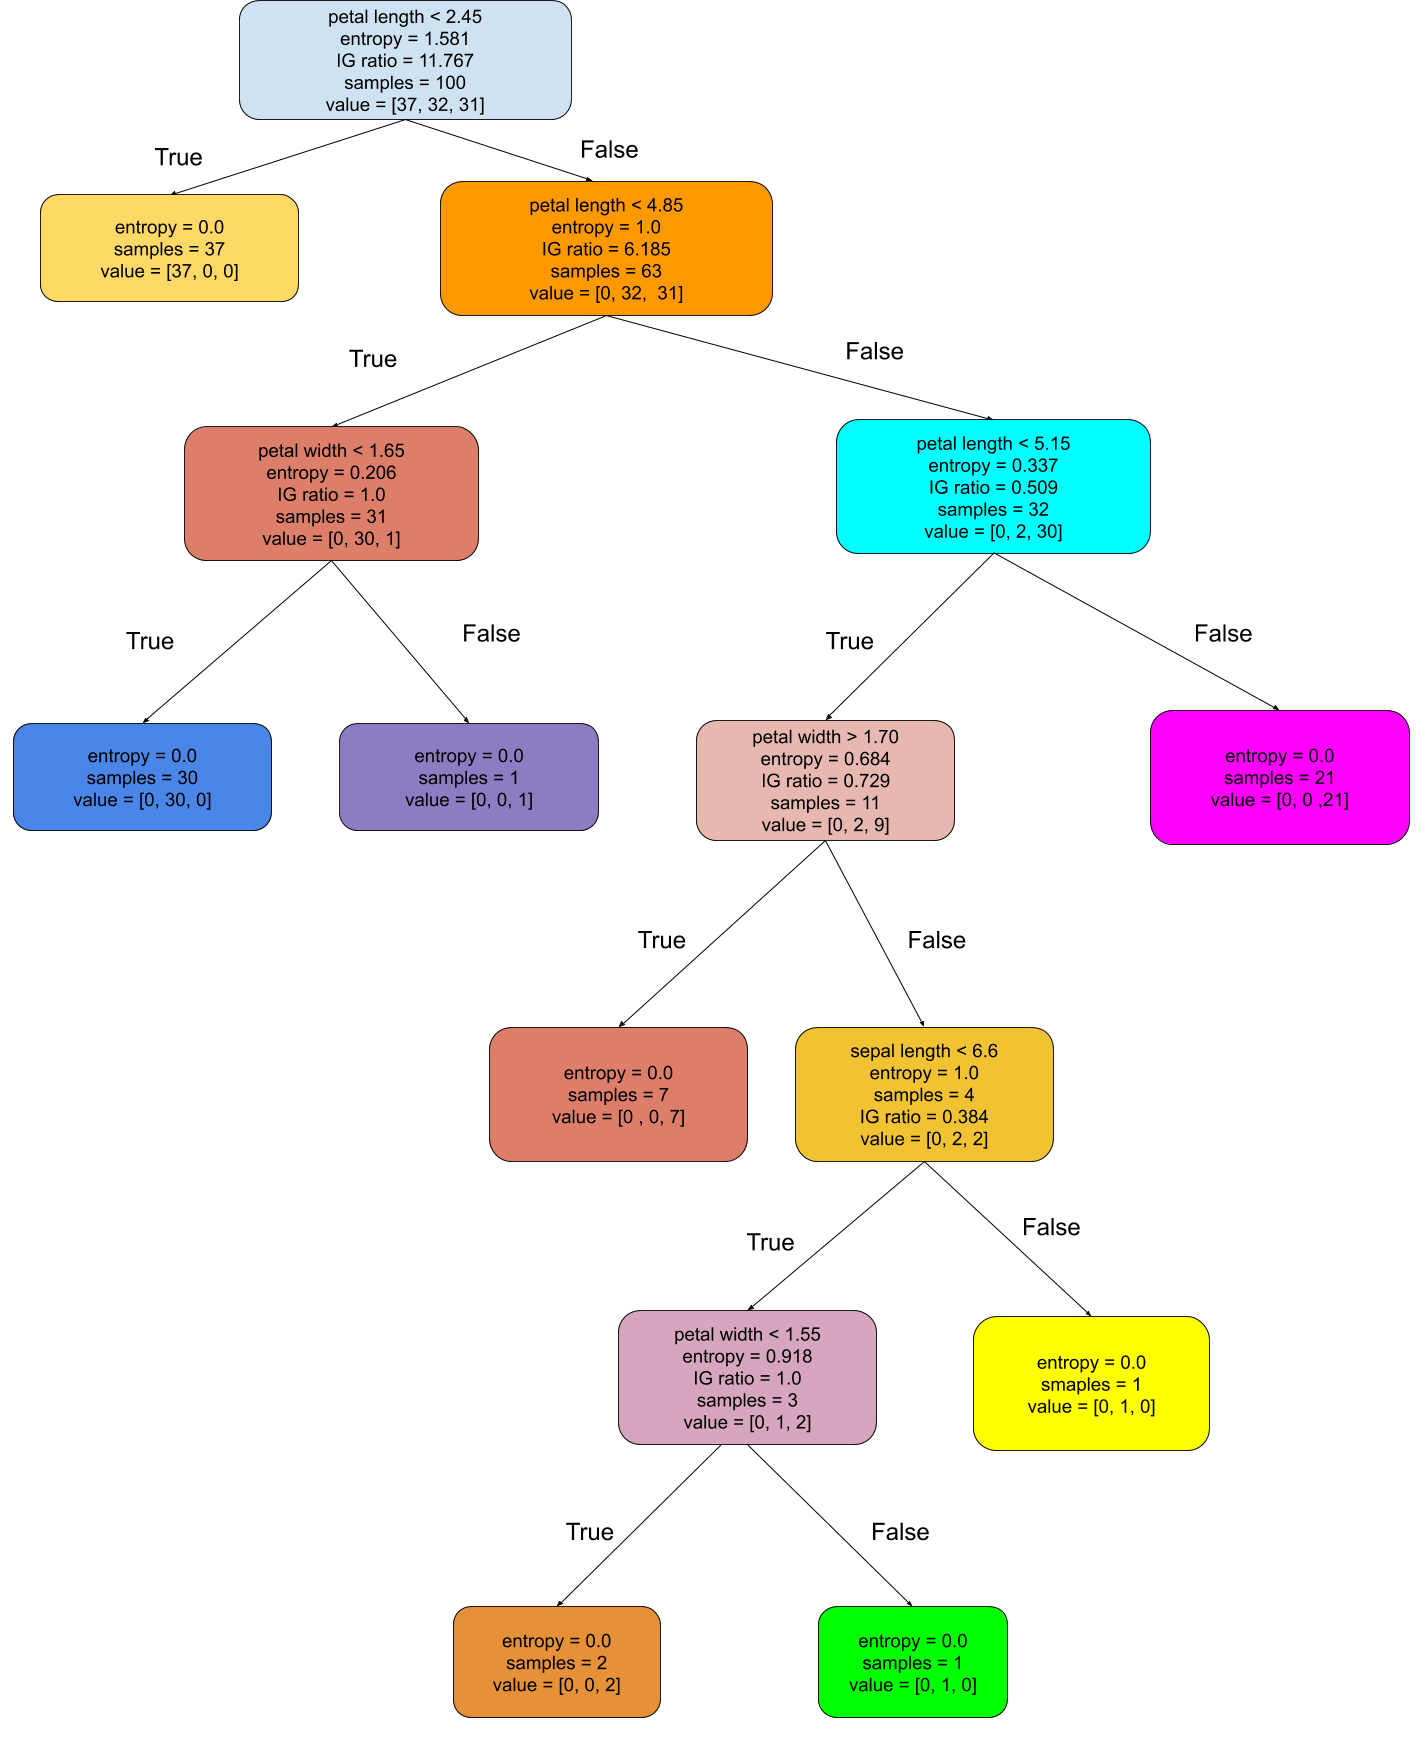

## **3. Model performance in scatter plot**

In this part, I choose a pair of attributes to train the models again and visualize the performance in the scatter plot.

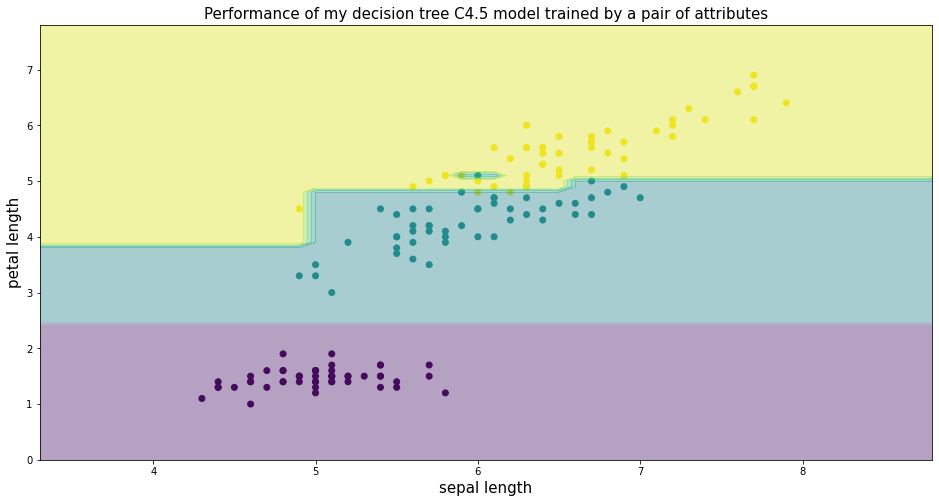

In [111]:
# select the first and third attributes columns to assign to separated_attr_X_total and separated_X_train
separated_attr_X_total = X_total.iloc[:,[0,2]]
separated_X_train = X_train.iloc[:,[0,2]]

x_min = separated_attr_X_total.iloc[:, 0].min() - 1
x_max = separated_attr_X_total.iloc[:, 0].max() + 1

y_min = separated_attr_X_total.iloc[:, 1].min() - 1
y_max = separated_attr_X_total.iloc[:, 1].max() + 1

# create two One-dimensional matrixs
X_d = np.arange(x_min, x_max, 0.1)
y_d = np.arange(y_min, y_max, 0.1)

# create two two-dimensional matrixs based on the X_d and y_d
xx, yy = np.meshgrid(X_d , y_d)

dt_se = TreeC4_5(separated_X_train,y_train)
dt_se.fit()

separeted_attribute1 = separated_X_train.keys()[0]
separeted_attribute2 = separated_X_train.keys()[1]

# use .ravel() return the one dimension view of xx and yy
# create a testing dataset
separated_X_test = pd.DataFrame({separeted_attribute1: xx.ravel(), separeted_attribute2: yy.ravel()})

separated_predictions = dt_se.predict(separated_X_test)

Z = np.array(separated_predictions)
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16,8))
plt.title("Performance of my decision tree C4.5 model trained by a pair of attributes", fontdict={"fontsize":15})
plt.xlabel(separeted_attribute1, fontsize=15)
plt.ylabel(separeted_attribute2, fontsize=15)

# visualize the total datasets point in scatter plot
plt.scatter(separated_attr_X_total.iloc[:, 0], separated_attr_X_total.iloc[:, 1], c = y_total)

# set the 3 areas according to the predictions of the model, each area stands for a label
# the "alpha" means the transparency, the main purpose of setting transparency is to see where the point is
plt.contourf(xx, yy, Z,alpha=0.4)
plt.show()

## **4. Comparison with the Decision Tree Model in sklearn library**




In this step, I use the DecisionTreeClassifier in sklearn library to train another model based on the same training datasets and testing datasets, and see the accuracy, errors_rate, and finally visualize the tree structure.

The reason why I use the decision tree model in sklearn is that I want to compare the performance of my C4.5 decision tree model with the sklearn model, including the accuracy, tree structure visualization.

In [112]:
from sklearn import tree 
import graphviz # This library is used to visualize the tree structure of the fitted decision tree model in sklearn

# choose the criterion = "Entropy" to measure the quality of a split by information gain.
clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=35)
clf = clf.fit(X_train,y_train)
predictions = clf.predict(X_test)

# calculate the accuracy from the predictions
result = [decision == target for decision,target in zip(predictions,y_test)]
accuracy = sum(result)/len(result)
print("sklearn decision tree model's accuracy for the iris dataset is:",accuracy)

sklearn decision tree model's accuracy for the iris dataset is: 0.94


It could be obviously observed that the sklearn decision tree model has similar accuracy to my C4.5 decision tree model.

Then I will use the DecisionTreeClassifier model to calculate the in-samples error rate and out of samples rate.

In [113]:
in_errs = []
out_errs = []
train_size = 0.66
for random_seed in range(10):
    X_trn, X_val, y_trn, y_val = train_test_split(
        X_total, y_total, train_size=train_size, random_state=random_seed)
    
    dt = tree.DecisionTreeClassifier(criterion="entropy")
    dt.fit(X_trn, y_trn) 
    
    in_sample_error_rate = np.sum((dt.predict(X_trn) != y_trn)) / len(y_trn)
    out_sample_error_rate = np.sum((dt.predict(X_val) != y_val)) / len(y_trn)

    in_errs.append(in_sample_error_rate)
    out_errs.append(out_sample_error_rate)

in_errs = np.array(in_errs)
out_errs = np.array(out_errs)
print(f"in_errs: mean {in_errs.mean():.2f}, std {in_errs.std():.2f}")
print(f"out_errs: mean {out_errs.mean():.2f}, std {out_errs.std():.2f}")

in_errs: mean 0.00, std 0.00
out_errs: mean 0.02, std 0.01


Then I Visualize the tree structure of the sklearn decision tree model by using the .export_graphviz() function

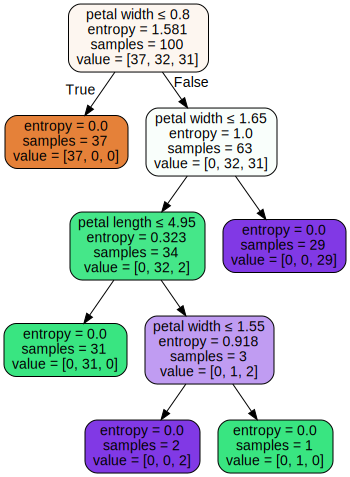

In [114]:
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=list(X_train.columns.values),filled=True,rounded=True,special_characters=True)
graphOfTree = graphviz.Source(dot_data)
graphOfTree

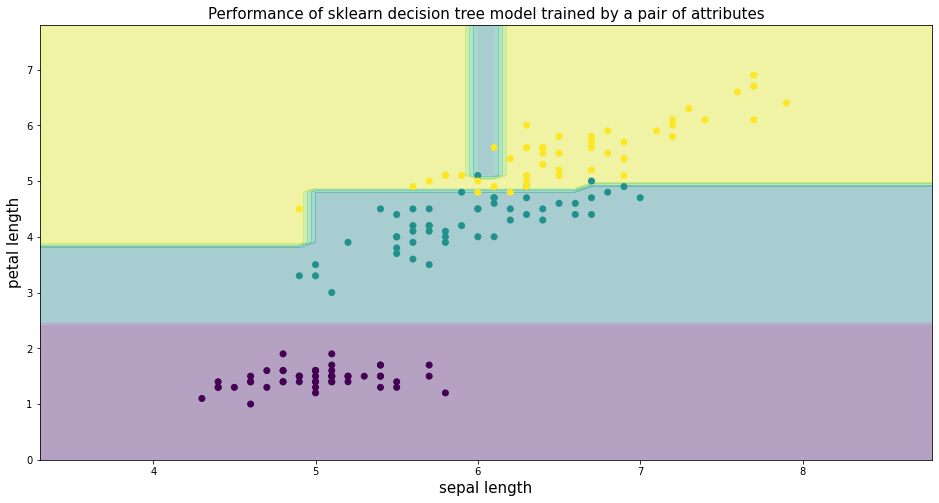

In [115]:
# select the first and third attributes columns to assign to separated_attr_X_total and separated_X_train
separated_attr_X_total = X_total.iloc[:,[0,2]]
separated_X_train = X_train.iloc[:,[0,2]]

x_min = separated_attr_X_total.iloc[:, 0].min() - 1
x_max = separated_attr_X_total.iloc[:, 0].max() + 1

y_min = separated_attr_X_total.iloc[:, 1].min() - 1
y_max = separated_attr_X_total.iloc[:, 1].max() + 1

# create two One-dimensional matrixs
X_d = np.arange(x_min, x_max, 0.1)
y_d = np.arange(y_min, y_max, 0.1)

# create two two-dimensional matrixs based on the X_d and y_d
xx, yy = np.meshgrid(X_d , y_d)

clf_se = tree.DecisionTreeClassifier()
clf_se.fit(np.array(separated_X_train),np.array(y_train))

# np.c_ means connecting the two matrices by column, that is, add the two matrices up and down, it requires the same number of columns
Z = clf_se.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(16,8))
plt.title("Performance of sklearn decision tree model trained by a pair of attributes", fontdict={"fontsize":15})
plt.xlabel(separeted_attribute1, fontsize=15)
plt.ylabel(separeted_attribute2, fontsize=15)
plt.contourf(xx, yy, Z,alpha=0.4)
plt.scatter(separated_attr_X_total.iloc[:, 0], separated_attr_X_total.iloc[:, 1], c = y_total)
plt.show()

Compare the scatter plot between my model and sklearn model, I notice there are almost the same except for the extra green rectangle area in the scatter plot of sklearn model.

## **5. Evaluation Datasets**

This part I will use another two datasets to test my C4.5 decision tree algorithm

**Evaluation dataset 1 - Blood Transfusion Service Center dataset**

This dataset has 748 samples with 5 attributes.

I use this dataset to evaluate whether my algorithm can handle some noise samples in the dataset.

It can be viewed and downloaded from the UCI Machine Learning Repository datasets: http://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center

In [116]:
df2 = pd.read_csv("https://raw.githubusercontent.com/ShengHangNB/Datasets/master/transfusion.csv")
df2.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [117]:
attrs2 = df2.keys()[:-1]
print("The number of samples in the total datasets are {}\n".format(df2.shape[0]))
X_total2 = df2[attrs2]
y_total2 = df2.iloc[:,-1]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_total2, y_total2, test_size = 0.33,random_state = 48)

print("The number of samples in the training datasets are {}".format(X_train2.shape[0]))
print("The number of samples in the testing datasets are {}".format(X_test2.shape[0]))

The number of samples in the total datasets are 748

The number of samples in the training datasets are 501
The number of samples in the testing datasets are 247


In [118]:
dt2 = TreeC4_5(X_train2,y_train2)
dt2.fit()

Issue happens!
The attribute values are the same, and the frequency of the target values is different.
Input values: 
     Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)
299                14                  2                    500             14
646                14                  2                    500             14
298                14                  2                    500             14
302                14                  2                    500             14
644                14                  2                    500             14
300                14                  2                    500             14
Target values: 
299    0
646    0
298    0
302    0
644    1
300    0
Name: whether he/she donated blood in March 2007, dtype: int64
Using the majority voting method to make a better decision ->  0
------------------------------------------------------------------------------------------------------------
Issue happens!
The att

In [119]:
decisions = dt2.predict(X_test2)
results = decisions == y_test2
accuracy = sum(results) / len(results)
print("My model's accuracy for the evaluation dataset 1 is: ", accuracy)

My model's accuracy for the evaluation dataset 1 is:  0.708502024291498


In [120]:
clf2 = tree.DecisionTreeClassifier(criterion="entropy",random_state=35)
clf2 = clf2.fit(X_train2,y_train2)
decisions = clf2.predict(X_test2)
result = [decision == target for decision,target in zip(decisions,y_test2)]
accuracy = sum(result)/len(result)
print("Sklearn model's accuracy for the evaluation dataset 1 is:",accuracy)

Sklearn model's accuracy for the evaluation dataset 1 is: 0.7246963562753036


**Evaluation of dataset 2 - Wine Quality dataset**

This dataset has 4898 samples with 12 numerical attributes.

I use this dataset to evaluate whether my algorithm can work well with the dataset with multiple attributes.

It can be viewed and downloaded from the UCI Machine Learning Repository datasets: https://archive.ics.uci.edu/ml/datasets/wine+quality

In [121]:
df3 = pd.read_csv("https://raw.githubusercontent.com/ShengHangNB/Datasets/master/winequality-red.csv")

# Here I randomly select 750 samples of the total
df3 = df3.sample(n=750, random_state=50, axis=0)

def change_target_type(x):
  if x > 6.5:
    return 'good'

  else:
    return 'not good'

df3.loc[:,"quality"] = df3["quality"].apply(change_target_type)
df3.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
453,10.4,0.33,0.63,2.8,0.084,5.0,22.0,0.99980,3.26,0.74,11.2,good
1415,6.2,0.58,0.00,1.6,0.065,8.0,18.0,0.99660,3.56,0.84,9.4,not good
1242,9.0,0.40,0.41,2.0,0.058,15.0,40.0,0.99414,3.22,0.60,12.2,not good
885,8.9,0.75,0.14,2.5,0.086,9.0,30.0,0.99824,3.34,0.64,10.5,not good
488,11.6,0.32,0.55,2.8,0.081,35.0,67.0,1.00020,3.32,0.92,10.8,good


In [122]:
attrs3 = df3.keys()[:-1]
print("The number of samples in the total datasets are {}\n".format(df3.shape[0]))
X_total3 = df3[attrs3]
y_total3 = df3.iloc[:,-1]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_total3, y_total3, test_size = 0.33,random_state = 48)


print("The number of samples in the training datasets are {}".format(X_train3.shape[0]))
print("The number of samples in the testing datasets are {}".format(X_test3.shape[0]))

The number of samples in the total datasets are 750

The number of samples in the training datasets are 502
The number of samples in the testing datasets are 248


In [123]:
dt3 = TreeC4_5(X_train3,y_train3)
dt3.fit()

In [124]:
decisions = dt3.predict(X_test3)
results = decisions == y_test3
accuracy = sum(results) / len(results)
print("My model's accuracy for the evaluation dataset 2 is: ", accuracy)

My model's accuracy for the evaluation dataset 2 is:  0.875


In [125]:
clf3 = tree.DecisionTreeClassifier(criterion="entropy",random_state=35)
clf3 = clf3.fit(X_train3,y_train3)
decisions = clf3.predict(X_test3)
result = [decision == target for decision,target in zip(decisions,y_test3)]
accuracy = sum(result)/len(result)
print("Sklearn model's accuracy for the evaluation dataset 2 is:",accuracy)

Sklearn model's accuracy for the evaluation dataset 2 is: 0.8588709677419355
